In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import time
import numpy as np
from sklearn.metrics import f1_score
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.6 MB/s eta 0:00:00


In [3]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

class ResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(ResNet, self).__init__()
        if (name == 'resnet50'):
            self.encoder = torchvision.models.resnet50(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(2048, num_classes)
        else:
            self.encoder = torchvision.models.resnet18(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
    def forward(self, x):

        return self.fc(self.encoder(x))



In [4]:
class Prj_Head(nn.Module):
    def __init__(self,in_dim,feature_dim):
        super(Prj_Head, self).__init__()
        
        self.g1 = nn.Sequential(nn.Linear(in_dim, 1024, bias=False),
                               nn.BatchNorm1d(1024),
                               nn.ReLU(inplace=True)
                               )
        self.g2 = nn.Sequential(nn.Linear(1024, 512, bias=False),
                                nn.BatchNorm1d(512),
                                nn.ReLU(inplace=True)
                                )
        self.g3=nn.Linear(512, feature_dim, bias=True)
    def forward(self, x):
        # print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=- 1) 
        x = self.g1(x)
        x = self.g2(x)
        x = self.g3(x)
        return x

In [5]:
class Encdr(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(Encdr, self).__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True, zero_init_residual=True)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):

        return self.fc(self.encoder(x))
    
    def add_feature(self):
        self.fc1=nn.Linear(512,2)

        

In [6]:
# datasets.py

import torch.utils.data as data
from PIL import Image
import numpy as np
import pandas as pd
import os

class OLIVES(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor




class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image



class RECOVERY_TEST(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor


In [7]:
# data_preprocessing.py

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from PIL import Image

def combine_excel(csv_dir):
    filenames = glob.glob(csv_dir + "/*.xlsx")
    outputxlsx = pd.DataFrame()

    for file in filenames:
        df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
        outputxlsx = outputxlsx.append(df, ignore_index=True)

    outputxlsx.to_csv('test_set_labels.csv',index=False)

def analyze_dataframe(csv_dir):
    pass

def process_images(csv_dir):
    df = pd.read_csv(csv_dir)

    for i in tqdm(range(0,len(df))):
        path = df.iloc[i,0]
        im = Image.open(path).convert('L')


def numpy_submission(sub_dir,np_dir):
    np_file  = np.load(np_dir)
    print(len(np_file))
    sub_dir = pd.read_csv(sub_dir)
    print(len(sub_dir))
    for i in range(0,len(sub_dir)):
        sub_dir.iloc[i,1] = np_file[i,0]
        sub_dir.iloc[i, 2] = np_file[i, 1]
        sub_dir.iloc[i, 3] = np_file[i, 2]
        sub_dir.iloc[i, 4] = np_file[i, 3]
        sub_dir.iloc[i, 5] = np_file[i, 4]
        sub_dir.iloc[i, 6] = np_file[i, 5]
    print(sub_dir.head())
    sub_dir.to_csv('baseline_result.csv',index=False)



    #process_images(csv_dir)

In [8]:
from __future__ import print_function

import math
import numpy as np
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
from torch.utils.data import random_split, Subset, SubsetRandomSampler

import torch.nn as nn
def set_model(opt, freeze = False):


    device = opt.device
    model = ResNet(name=opt.model,num_classes = opt.ncls)
    if freeze:
        model.encoder.requires_grad_(False)
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion


# model for self supervised training

def set_model_st(opt,Net):


    device = opt.device
    #model = Encdr(name=opt.model,num_classes = opt.ncls)
    model = nn.Sequential(
    Net, 
    nn.Linear(512, 1024, bias=False),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 6, bias=True))
    
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion




def set_loader(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.85, 1.)),
        transforms.RandomRotation(30), 
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        val_dataset = OLIVES(csv_path_valid,data_path_train,transforms = val_transform)
        test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
        
        # Create a random sampler for the subset
        np.random.seed(unlabel_seed)
        random_indices = np.random.choice(len(unlabelled_train_dataset), unlabel_count, replace=False)
        subset_sampler = SubsetRandomSampler(random_indices)

    else:
        raise ValueError(opt.dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(unlabelled_train_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, unlabelled_train_loader




class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def set_optimizer(opt, model):

    optimizer = optim.SGD(model.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=opt.learning_rate)

    return optimizer


def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state
    
def save_model_unsupervised(net, projection_head, save_file):
    print('==> Saving...')
    state = {
        'net': net.state_dict(),
        'head': projection_head.state_dict()
    }
    torch.save(state, save_file)
    del state

In [9]:
import torch.utils.data

def set_unlabel_loader(opt, unlabel_seed, unlabel_count):
    # construct data loader
    mean = (.1706)
    std = (.2112)

    normalize = transforms.Normalize(mean=mean, std=std)

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    
    data_path_train = opt.train_image_path
    data_path_test = opt.test_image_path
    
    unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
    test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
    
    full_dataset = torch.utils.data.ConcatDataset([unlabelled_train_dataset, test_dataset])

    # Create a random sampler for the subset
    np.random.seed(unlabel_seed)
    random_indices = np.random.choice(len(full_dataset), unlabel_count, replace=False)
    subset_sampler = SubsetRandomSampler(random_indices)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(full_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return unlabelled_train_loader


In [10]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F

class Noise(object):
    def __init__(self, amount=0.3, brightness=0.2):
        self.noise = 200
        self.amount = amount
        self.brightness = brightness
        
    def __call__(self, x):
        dark_region_indices = torch.where(x < self.brightness)
        dark_region_coords = torch.stack(dark_region_indices, dim=-1)

        # Randomly select pixels from dark regions for adding noise
        pixels = torch.randint(0, int(self.amount * 224 * 224), size=(1,))
        selected_coords = dark_region_coords[torch.randperm(dark_region_coords.size(0))[:pixels]]

        image = x.clone()
        # Add salt noise (white pixels)
        noise = np.random.randint(self.noise, 250)
        image[selected_coords[:, 0], selected_coords[:, 1], selected_coords[:, 2]] = noise
        
        return image

In [11]:
torch.randint(0, 112, size=(1,))

tensor([86])

In [12]:
#----------------------------------------------------------------------------------------------------
# Augmentations
from torchvision import transforms
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""
    """Borrowed from MoCo implementation"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
class FixedRandomRotation:
    """Rotate by one of the given angles."""
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    
def torchvision_transforms(eval=False, aug=None):

    trans = []

    if aug["resize"]:
        trans.append(transforms.Resize(aug["resize"]))

    if aug["randcrop"] and aug["scale"] and not eval:
        trans.append(transforms.RandomResizedCrop(aug["randcrop"], scale=aug["scale"]))

    if aug["randcrop"] and eval:
        trans.append(transforms.CenterCrop(aug["randcrop"]))

    if aug["flip"] and not eval:
        trans.append(transforms.RandomHorizontalFlip(p=0.5))
        trans.append(transforms.RandomVerticalFlip(p=0.5))

    if aug["jitter_d"] and not eval:
        trans.append(transforms.RandomApply(
            [transforms.ColorJitter(0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.2*aug["jitter_d"])],
             p=aug["jitter_p"]))

    if aug["gaussian_blur"] and not eval:
        trans.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1,.2))], p=aug["gaussian_blur"]))

    if aug["rotation"] and not eval:
        # rotation_transform = FixedRandomRotation(angles=[0, 90, 180, 270])
        trans.append(transforms.RandomRotation(30))

    trans.append(Noise())

    trans = transforms.Compose(trans)
   
    return trans
aug = {"resize":0,
    "randcrop":224,
      "scale": (0.85, 1.0),
      "flip":0,
      "jitter_d":0.3,
       "jitter_p":0.3,
       "gaussian_blur":0.5,
       "rotation":1
      }
augmentations = torchvision_transforms(aug = aug)
print(augmentations)




Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomApply(
    p=0.3
    ColorJitter(brightness=(0.76, 1.24), contrast=(0.76, 1.24), saturation=(0.76, 1.24), hue=(-0.06, 0.06))
)
    RandomApply(
    p=0.5
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2))
)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
)


In [13]:
# config.py

import argparse
import math
import os

def parse_option(string):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=8,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs')
    parser.add_argument('--device', type=str, default='cuda:0')
    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--patient_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--cluster_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='100',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')
    parser.add_argument('--train_csv_path', type=str, default='train data csv')
    parser.add_argument('--test_csv_path', type=str, default='test data csv')
    parser.add_argument('--train_image_path', type=str, default='train data csv')
    parser.add_argument('--test_image_path', type=str, default='test data csv')

    parser.add_argument('--parallel', type=int, default=1, help='data parallel')
    parser.add_argument('--ncls', type=int, default=6, help='Number of Classes')
    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='TREX_DME',
                        choices=[ 'OLIVES'], help='dataset')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=128, help='parameter for RandomResizedCrop')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')



    opt = parser.parse_args(string)

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
               and opt.mean is not None \
               and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = './datasets/'
    opt.model_path = './save/{}_models'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_lr_{}_decay_{}_bsz_{}_temp_{}'. \
        format(opt.model, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp)


    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt

In [14]:
from pytorch_metric_learning.losses import NTXentLoss
ss_loss_func = NTXentLoss(temperature=0.10)

def train_ss(Net,projection_head,data_loader, epoch, print_freq = 10):
    Net.train()
    projection_head.train()
    total_loss = AverageMeter()
    for idx, x in enumerate(data_loader): 
        # print(batch_idx)
        optimizer.zero_grad()
        # Get data representations
        x = x.to(device)
        
        A1 = augmentations(x)
        A2 = augmentations(x)
        
        h1 = Net(A1)
        z1 = projection_head(h1)
        
        h2 = Net(A2)
        z2 = projection_head(h2)
        
        # Prepare for loss
        embeddings = torch.cat((z1, z2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, z1.size(0), device=z2.device)
        labels = torch.cat((indices, indices))
        loss = ss_loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss.update(loss.data.item())
        
        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(data_loader)))
            
        del x, A1, A2
            
    return total_loss.avg

In [15]:
def train_supervised(train_loader, val_loader, model,criterion, optimizer, epoch, opt):
    """one epoch training"""
    model.train()


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = opt.device
    end = time.time()
    correct_predictions = 0

    for idx, (image, bio_tensor) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss
        output = model(images)
        loss = criterion(output, labels)
        
        # Calculate training accuracy
        predicted_labels = torch.round(torch.sigmoid(output)) 
        correct_predictions += (predicted_labels == labels).sum().item()

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % 10 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(train_loader)))

            sys.stdout.flush()

    total_values = len(train_loader.dataset) * 6
    training_accuracy = (correct_predictions / total_values) * 100.0
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print("Training loss:", losses.avg)
    
    return losses.avg


In [16]:
def submission_generate(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission{epoch}.csv", index = False)


In [17]:
def sample_evaluation(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print("Validation accuracy:", (correct_count / total_count) * 100, "%")

    label_array = np.array(label_list)
    out_array = np.array(out_list)
    f = f1_score(label_array,out_array,average='macro')
    print("Validation F1:", f)
    
    return f

In [18]:
def sample_evaluation_acc(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            #label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            #out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print((correct_count / total_count) * 100, "%")



In [19]:
def load_model(model, load_file, key = 'model'):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    model.load_state_dict(checkpoint[key])
    return model

def load_model_unsupervised(net, head, load_file):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    net.load_state_dict(checkpoint['net'])
    head.load_state_dict(checkpoint['head'])
    return model

In [20]:
if not os.path.isdir('/kaggle/working/supervised'):
    os.makedirs('/kaggle/working/supervised')
if not os.path.isdir('/kaggle/working/unsupervised'):
    os.makedirs('/kaggle/working/unsupervised')

In [21]:
args = args = ['--batch_size', '64', '--model', "resnet50", '--dataset', 'OLIVES', '--epochs', '2', '--device', 'cuda:0', '--train_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TRAIN/OLIVES', '--test_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/', '--test_csv_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv', '--train_csv_path', '/kaggle/input/olives-training-labels/Training_Biomarker_Data.csv']
opt = parse_option(args)

# CSV paths
csv_path_train = "/kaggle/input/olives-training-labels/training_split_biomarker_data.csv"
csv_path_valid = "/kaggle/input/olives-training-labels/validation_biomarker_data.csv"
csv_path_test = "/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv"
csv_path_unlabelled = "/kaggle/input/olives-training-labels/unlabelled_images.csv"

In [22]:
# build data loader
unlabel_count = 20000
unlabel_seed = 1231
opt.batch_size = 64
train_loader, val_loader, test_loader, unlabelled_train_loader = set_loader(opt)
unlabelled_train_loader = set_unlabel_loader(opt, unlabel_seed, unlabel_count)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
len(unlabelled_train_loader)

313

In [24]:
##### UNSUPERVISED LEARNING PART

In [25]:
#--------------------------------------------------------------------------
device = torch.device("cuda:0" )
Net = Encdr().to(device)
projection_head = Prj_Head(512,128).to(device)

optimizer = torch.optim.Adam(list(Net.parameters())+list(projection_head.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

#train(Net,projection_head,train_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.5MB/s]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train: [1][50/313]	
Train: [1][100/313]	
Train: [1][150/313]	
Train: [1][200/313]	
Train: [1][250/313]	
Train: [1][300/313]	
Epoch   1, Loss: 4.5482
==> Saving...
Train: [2][50/313]	
Train: [2][100/313]	
Train: [2][150/313]	
Train: [2][200/313]	
Train: [2][250/313]	
Train: [2][300/313]	
Epoch   2, Loss: 4.1480
==> Saving...
Train: [3][50/313]	
Train: [3][100/313]	
Train: [3][150/313]	
Train: [3][200/313]	
Train: [3][250/313]	
Train: [3][300/313]	
Epoch   3, Loss: 3.9860
==> Saving...
Train: [4][50/313]	
Train: [4][100/313]	
Train: [4][150/313]	
Train: [4][200/313]	
Train: [4][250/313]	
Train: [4][300/313]	
Epoch   4, Loss: 3.0918
==> Saving...
Train: [5][50/313]	
Train: [5][100/313]	
Train: [5][150/313]	
Train: [5][200/313]	
Train: [5][250/313]	
Train: [5][300/313]	
Epoch   5, Loss: 1.6729
==> Saving...
Dataset changed, indices = [110516 145986  68965 ... 118184   6527  88061]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [6][50/313]	
Train: [6][100/313]	
Train: [6][150/313]	
Train: [6][200/313]	
Train: [6][250/313]	
Train: [6][300/313]	
Epoch   6, Loss: 0.8505
==> Saving...
Train: [7][50/313]	
Train: [7][100/313]	
Train: [7][150/313]	
Train: [7][200/313]	
Train: [7][250/313]	
Train: [7][300/313]	
Epoch   7, Loss: 0.6215
==> Saving...
Train: [8][50/313]	
Train: [8][100/313]	
Train: [8][150/313]	
Train: [8][200/313]	
Train: [8][250/313]	
Train: [8][300/313]	
Epoch   8, Loss: 0.4744
==> Saving...
Train: [9][50/313]	
Train: [9][100/313]	
Train: [9][150/313]	
Train: [9][200/313]	
Train: [9][250/313]	
Train: [9][300/313]	
Epoch   9, Loss: 0.3831
==> Saving...
Train: [10][50/313]	
Train: [10][100/313]	
Train: [10][150/313]	
Train: [10][200/313]	
Train: [10][250/313]	
Train: [10][300/313]	
Epoch  10, Loss: 0.3219
==> Saving...
==> Saving...
Dataset changed, indices = [120672 151355 140318 ...  92501  61615 114141]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [11][50/313]	
Train: [11][100/313]	
Train: [11][150/313]	
Train: [11][200/313]	
Train: [11][250/313]	
Train: [11][300/313]	
Epoch  11, Loss: 0.2603
==> Saving...
Train: [12][50/313]	
Train: [12][100/313]	
Train: [12][150/313]	
Train: [12][200/313]	
Train: [12][250/313]	
Train: [12][300/313]	
Epoch  12, Loss: 0.2821
Train: [13][50/313]	
Train: [13][100/313]	
Train: [13][150/313]	
Train: [13][200/313]	
Train: [13][250/313]	
Train: [13][300/313]	
Epoch  13, Loss: 0.2245
==> Saving...
Train: [14][50/313]	
Train: [14][100/313]	
Train: [14][150/313]	
Train: [14][200/313]	
Train: [14][250/313]	
Train: [14][300/313]	
Epoch  14, Loss: 0.2231
==> Saving...
Train: [15][50/313]	
Train: [15][100/313]	
Train: [15][150/313]	
Train: [15][200/313]	
Train: [15][250/313]	
Train: [15][300/313]	
Epoch  15, Loss: 0.1920
==> Saving...
Dataset changed, indices = [107003 107557 107710 ...  79790  38478  68877]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [16][50/313]	
Train: [16][100/313]	
Train: [16][150/313]	
Train: [16][200/313]	
Train: [16][250/313]	
Train: [16][300/313]	
Epoch  16, Loss: 0.2182
Train: [17][50/313]	
Train: [17][100/313]	
Train: [17][150/313]	
Train: [17][200/313]	
Train: [17][250/313]	
Train: [17][300/313]	
Epoch  17, Loss: 0.1667
==> Saving...
Train: [18][50/313]	
Train: [18][100/313]	
Train: [18][150/313]	
Train: [18][200/313]	
Train: [18][250/313]	
Train: [18][300/313]	
Epoch  18, Loss: 0.1936
Train: [19][50/313]	
Train: [19][100/313]	
Train: [19][150/313]	
Train: [19][200/313]	
Train: [19][250/313]	
Train: [19][300/313]	
Epoch  19, Loss: 0.1437
==> Saving...
Train: [20][50/313]	
Train: [20][100/313]	
Train: [20][150/313]	
Train: [20][200/313]	
Train: [20][250/313]	
Train: [20][300/313]	
Epoch  20, Loss: 0.1288
==> Saving...
==> Saving...
Dataset changed, indices = [ 18652  42803 117833 ... 140832 144561  69073]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [21][50/313]	
Train: [21][100/313]	
Train: [21][150/313]	
Train: [21][200/313]	
Train: [21][250/313]	
Train: [21][300/313]	
Epoch  21, Loss: 0.1077
==> Saving...
Train: [22][50/313]	
Train: [22][100/313]	
Train: [22][150/313]	
Train: [22][200/313]	
Train: [22][250/313]	
Train: [22][300/313]	
Epoch  22, Loss: 0.1033
==> Saving...
Train: [23][50/313]	
Train: [23][100/313]	
Train: [23][150/313]	
Train: [23][200/313]	
Train: [23][250/313]	
Train: [23][300/313]	
Epoch  23, Loss: 0.1065
Train: [24][50/313]	
Train: [24][100/313]	
Train: [24][150/313]	
Train: [24][200/313]	
Train: [24][250/313]	
Train: [24][300/313]	
Epoch  24, Loss: 0.1340
Train: [25][50/313]	
Train: [25][100/313]	
Train: [25][150/313]	
Train: [25][200/313]	
Train: [25][250/313]	
Train: [25][300/313]	
Epoch  25, Loss: 0.1040
Dataset changed, indices = [ 74308  81567  38810 ... 147735  72543 125353]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [26][50/313]	
Train: [26][100/313]	
Train: [26][150/313]	
Train: [26][200/313]	
Train: [26][250/313]	
Train: [26][300/313]	
Epoch  26, Loss: 0.0938
==> Saving...
Train: [27][50/313]	
Train: [27][100/313]	
Train: [27][150/313]	
Train: [27][200/313]	
Train: [27][250/313]	
Train: [27][300/313]	
Epoch  27, Loss: 0.0935
==> Saving...
Train: [28][50/313]	
Train: [28][100/313]	
Train: [28][150/313]	
Train: [28][200/313]	
Train: [28][250/313]	
Train: [28][300/313]	
Epoch  28, Loss: 0.0870
==> Saving...
Train: [29][50/313]	
Train: [29][100/313]	
Train: [29][150/313]	
Train: [29][200/313]	
Train: [29][250/313]	
Train: [29][300/313]	
Epoch  29, Loss: 0.0879
Train: [30][50/313]	
Train: [30][100/313]	
Train: [30][150/313]	
Train: [30][200/313]	
Train: [30][250/313]	
Train: [30][300/313]	
Epoch  30, Loss: 0.0868
==> Saving...
==> Saving...
Dataset changed, indices = [ 78581  43739   4753 ... 106216 148004  74997]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [31][50/313]	
Train: [31][100/313]	
Train: [31][150/313]	
Train: [31][200/313]	
Train: [31][250/313]	
Train: [31][300/313]	
Epoch  31, Loss: 0.0911
Train: [32][50/313]	
Train: [32][100/313]	
Train: [32][150/313]	
Train: [32][200/313]	
Train: [32][250/313]	
Train: [32][300/313]	
Epoch  32, Loss: 0.0857
==> Saving...
Train: [33][50/313]	
Train: [33][100/313]	
Train: [33][150/313]	
Train: [33][200/313]	
Train: [33][250/313]	
Train: [33][300/313]	
Epoch  33, Loss: 0.0970
Train: [34][50/313]	
Train: [34][100/313]	
Train: [34][150/313]	
Train: [34][200/313]	
Train: [34][250/313]	
Train: [34][300/313]	
Epoch  34, Loss: 0.0837
==> Saving...
Train: [35][50/313]	
Train: [35][100/313]	
Train: [35][150/313]	
Train: [35][200/313]	
Train: [35][250/313]	
Train: [35][300/313]	
Epoch  35, Loss: 0.0782
==> Saving...
Dataset changed, indices = [101959  86095 114908 ... 109590 125422   3434]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [36][50/313]	
Train: [36][100/313]	
Train: [36][150/313]	
Train: [36][200/313]	
Train: [36][250/313]	
Train: [36][300/313]	
Epoch  36, Loss: 0.0729
==> Saving...
Train: [37][50/313]	
Train: [37][100/313]	
Train: [37][150/313]	
Train: [37][200/313]	
Train: [37][250/313]	
Train: [37][300/313]	
Epoch  37, Loss: 0.0853
Train: [38][50/313]	
Train: [38][100/313]	
Train: [38][150/313]	
Train: [38][200/313]	
Train: [38][250/313]	
Train: [38][300/313]	
Epoch  38, Loss: 0.0841
Train: [39][50/313]	
Train: [39][100/313]	
Train: [39][150/313]	
Train: [39][200/313]	
Train: [39][250/313]	
Train: [39][300/313]	
Epoch  39, Loss: 0.1015
Train: [40][50/313]	
Train: [40][100/313]	
Train: [40][150/313]	
Train: [40][200/313]	
Train: [40][250/313]	
Train: [40][300/313]	
Epoch  40, Loss: 0.0752
==> Saving...
Dataset changed, indices = [138167 141905  37643 ... 149843  35181  95055]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [41][50/313]	
Train: [41][100/313]	
Train: [41][150/313]	
Train: [41][200/313]	
Train: [41][250/313]	
Train: [41][300/313]	
Epoch  41, Loss: 0.0626
==> Saving...
Train: [42][50/313]	
Train: [42][100/313]	
Train: [42][150/313]	
Train: [42][200/313]	
Train: [42][250/313]	
Train: [42][300/313]	
Epoch  42, Loss: 0.0585
==> Saving...
Train: [43][50/313]	
Train: [43][100/313]	
Train: [43][150/313]	
Train: [43][200/313]	
Train: [43][250/313]	
Train: [43][300/313]	
Epoch  43, Loss: 0.0778
Train: [44][50/313]	
Train: [44][100/313]	
Train: [44][150/313]	
Train: [44][200/313]	
Train: [44][250/313]	
Train: [44][300/313]	
Epoch  44, Loss: 0.0593
Train: [45][50/313]	
Train: [45][100/313]	
Train: [45][150/313]	
Train: [45][200/313]	
Train: [45][250/313]	
Train: [45][300/313]	
Epoch  45, Loss: 0.0545
==> Saving...
Dataset changed, indices = [  5308 103566 110248 ...  94124  63670  63560]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [46][50/313]	
Train: [46][100/313]	
Train: [46][150/313]	
Train: [46][200/313]	
Train: [46][250/313]	
Train: [46][300/313]	
Epoch  46, Loss: 0.0553
Train: [47][50/313]	
Train: [47][100/313]	
Train: [47][150/313]	
Train: [47][200/313]	
Train: [47][250/313]	
Train: [47][300/313]	
Epoch  47, Loss: 0.0549
Train: [48][50/313]	
Train: [48][100/313]	
Train: [48][150/313]	
Train: [48][200/313]	
Train: [48][250/313]	
Train: [48][300/313]	
Epoch  48, Loss: 0.0536
==> Saving...
Train: [49][50/313]	
Train: [49][100/313]	
Train: [49][150/313]	
Train: [49][200/313]	
Train: [49][250/313]	
Train: [49][300/313]	
Epoch  49, Loss: 0.0554
Train: [50][50/313]	
Train: [50][100/313]	
Train: [50][150/313]	
Train: [50][200/313]	
Train: [50][250/313]	
Train: [50][300/313]	
Epoch  50, Loss: 0.0547
==> Saving...
Dataset changed, indices = [113683  62606  34779 ...  64695 113256 108965]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [51][50/313]	
Train: [51][100/313]	
Train: [51][150/313]	
Train: [51][200/313]	
Train: [51][250/313]	
Train: [51][300/313]	
Epoch  51, Loss: 0.0489
==> Saving...
Train: [52][50/313]	
Train: [52][100/313]	
Train: [52][150/313]	
Train: [52][200/313]	
Train: [52][250/313]	
Train: [52][300/313]	
Epoch  52, Loss: 0.0514
Train: [53][50/313]	
Train: [53][100/313]	
Train: [53][150/313]	
Train: [53][200/313]	
Train: [53][250/313]	
Train: [53][300/313]	
Epoch  53, Loss: 0.0587
Train: [54][50/313]	
Train: [54][100/313]	
Train: [54][150/313]	
Train: [54][200/313]	
Train: [54][250/313]	
Train: [54][300/313]	
Epoch  54, Loss: 0.0497
Train: [55][50/313]	
Train: [55][100/313]	
Train: [55][150/313]	
Train: [55][200/313]	
Train: [55][250/313]	
Train: [55][300/313]	
Epoch  55, Loss: 0.0572
Dataset changed, indices = [53080 99346 54806 ... 25640 75564 67222]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Train: [56][50/313]	
Train: [56][100/313]	
Train: [56][150/313]	
Train: [56][200/313]	
Train: [56][250/313]	
Train: [56][300/313]	
Epoch  56, Loss: 0.0483
==> Saving...
Train: [57][50/313]	
Train: [57][100/313]	
Train: [57][150/313]	
Train: [57][200/313]	
Train: [57][250/313]	
Train: [57][300/313]	
Epoch  57, Loss: 0.0436
==> Saving...
Train: [58][50/313]	
Train: [58][100/313]	
Train: [58][150/313]	
Train: [58][200/313]	
Train: [58][250/313]	
Train: [58][300/313]	
Epoch  58, Loss: 0.0446
Train: [59][50/313]	
Train: [59][100/313]	
Train: [59][150/313]	
Train: [59][200/313]	
Train: [59][250/313]	
Train: [59][300/313]	
Epoch  59, Loss: 0.0414
==> Saving...
Train: [60][50/313]	
Train: [60][100/313]	
Train: [60][150/313]	
Train: [60][200/313]	
Train: [60][250/313]	
Train: [60][300/313]	
Epoch  60, Loss: 0.0450
==> Saving...
Dataset changed, indices = [152911 153011  59879 ...  32255  13534   2234]


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


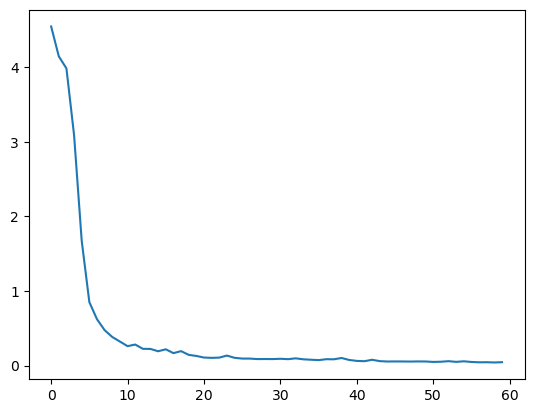

In [26]:
n_epoch = 60
loss_list = []
best_loss = 10000
save_file = os.path.join(opt.save_folder + 'models', 'last.pth')
#save_model(model, optimizer, opt, opt.epochs, save_file)

for epoch in range(1, n_epoch + 1):
    loss = train_ss(Net,projection_head,unlabelled_train_loader, epoch, print_freq = 50)
    print(f'Epoch {epoch:3d}, Loss: {loss:.4f}')
    scheduler.step()
    loss_list.append(loss)
    if loss<best_loss:
        best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_best_loss.pth.tar') 
        save_model_unsupervised(Net, projection_head, '/kaggle/working/unsupervised/best_loss.pth')
    if epoch % 10 == 0:
        #best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_checkpoint.pth.tar') 
        save_model_unsupervised(Net, projection_head, f'/kaggle/working/unsupervised/epoch{epoch}.pth')
        
    if epoch % 5 == 0:
        unlabelled_train_loader = set_unlabel_loader(opt, np.random.randint(1, 100000), unlabel_count)
        print("Dataset changed, indices =", unlabelled_train_loader.sampler.indices)
        
#torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_final_checkpoint.pth.tar') 
plt.figure()
plt.plot(loss_list)

In [27]:
###### SUPERVISED LEARNING PART 

In [28]:
# If loading pretrained
load_file = "/kaggle/input/models/pretrain_unsupervised.pth"  # change to model path
device = torch.device("cuda:0" )
Net = Encdr().to(device)
Net = load_model(Net, load_file, "model")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Loading...


In [29]:
#Net.add_feature()
model, criterion = set_model_st(opt, Net)    
optimizer = set_optimizer(opt, model)

In [30]:
# To check performance without the pre training
#model, criterion = set_model(opt)    
#optimizer = set_optimizer(opt, model)

In [31]:
# training routine with freezing
#model[0].requires_grad_(False)
#opt.learning_rate = 0.05
#for epoch in range(1, 15+1):
#    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)

In [32]:
# training routine without freezing
model[0].requires_grad_(True)
opt.learning_rate = 0.005

best_f1 = 0.50
for epoch in range(1, 0+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 10 == 0:
        submission_generate(test_loader, model, opt, epoch)
    

In [33]:
save_file = os.path.join('/kaggle/working/supervised/last.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

==> Saving...


In [34]:
# Validation
sample_evaluation(val_loader, model, opt)

Validation accuracy: 51.49659863945578 %
Validation F1: 0.14034180630637264


0.14034180630637264

In [35]:
submission_generate(test_loader, model, opt)